In [6]:
import dgl
import mxnet as mx
from matplotlib import pyplot as plt
import gluoncv as gcv
from gluoncv.data.transforms import presets
from model import faster_rcnn_resnet101_v1d_custom, RelDN
from utils import *
from data import *

plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
ctx=mx.gpu()
net = RelDN(n_classes=50, prior_pkl='freq_prior.pkl',
            semantic_only=False)
net.load_parameters('params_resnet101_v1d_reldn/model-8.params', ctx=ctx)

# dataset and dataloader
vg_val = VGRelation(split='val')
detector = faster_rcnn_resnet101_v1d_custom(classes=vg_val.obj_classes,
                                            pretrained_base=False, pretrained=False,
                                            additional_output=True)
params_path = 'faster_rcnn_resnet101_v1d_visualgenome/faster_rcnn_resnet101_v1d_custom_best.params'
detector.load_parameters(params_path, ctx=ctx, ignore_extra=True, allow_missing=True)

detector_feat = faster_rcnn_resnet101_v1d_custom(classes=vg_val.obj_classes,
                                                 pretrained_base=False, pretrained=False,
                                                 additional_output=True)
detector_feat.load_parameters(params_path, ctx=ctx, ignore_extra=True, allow_missing=True)

detector_feat.features.load_parameters('params_resnet101_v1d_reldn/detector_feat.features-8.params', ctx=ctx)

In [3]:
x, img = presets.rcnn.load_test('burnaby.png', short=detector.short, max_size=detector.max_size)

In [4]:
x = x.as_in_context(ctx)
ids, scores, bboxes, feat, feat_ind, spatial_feat = detector(x)

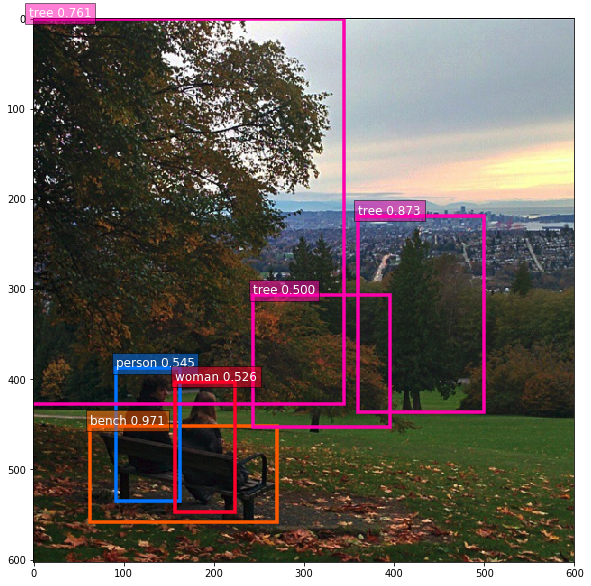

In [7]:
ax = gcv.utils.viz.plot_bbox(img, bboxes[0], scores[0], ids[0], thresh=0.5,
                             class_names=detector.classes, ax=None)
plt.show()

In [8]:
g = build_graph_validate_pred(x, ids, scores, bboxes, feat_ind, spatial_feat, bbox_improvement=True, scores_top_k=75, overlap=False)

In [9]:
g

DGLGraph(num_nodes=75, num_edges=5550,
         ndata_schemes={'pred_bbox': Scheme(shape=(5,), dtype=<class 'numpy.float32'>), 'node_feat': Scheme(shape=(49,), dtype=<class 'numpy.float32'>), 'node_class_pred': Scheme(shape=(), dtype=<class 'numpy.float32'>), 'node_class_logit': Scheme(shape=(), dtype=<class 'numpy.float32'>)}
         edata_schemes={'rel_bbox': Scheme(shape=(4,), dtype=<class 'numpy.float32'>), 'batch_id': Scheme(shape=(1,), dtype=<class 'numpy.float32'>)})

In [10]:
rel_bbox = g.edata['rel_bbox'].expand_dims(0).as_in_context(ctx)
_, _, _, spatial_feat_rel = detector_feat(x, None, None, rel_bbox)
g.edata['edge_feat'] = spatial_feat_rel[0]
g = net(g)

In [11]:
_, preds = extract_pred(g, joint_preds=True)
preds = preds[preds[:,1].argsort()[::-1]]

In [12]:
def plot_sg(img, preds, topk):
    size = img.shape[0:2]
    box_scale = np.array([size[1], size[0], size[1], size[0]])
    topk = min(topk, preds.shape[0])
    ax = gcv.utils.viz.plot_image(img)
    for i in range(topk):
        rel = int(preds[i, 2])
        src = int(preds[i, 3])
        dst = int(preds[i, 4])
        src_name = detector.classes[src]
        dst_name = detector.classes[dst]
        rel_name = vg_val.rel_classes[rel]
        # import pdb; pdb.set_trace()
        src_bbox = preds[i, 5:9] * box_scale
        dst_bbox = preds[i, 9:13] * box_scale
        
        src_center = np.array([(src_bbox[0] + src_bbox[2]) / 2, (src_bbox[1] + src_bbox[3]) / 2])
        dst_center = np.array([(dst_bbox[0] + dst_bbox[2]) / 2, (dst_bbox[1] + dst_bbox[3]) / 2])
        rel_center = (src_center + dst_center) / 2
        
        line_x = np.array([(src_bbox[0] + src_bbox[2]) / 2, (dst_bbox[0] + dst_bbox[2]) / 2])
        line_y = np.array([(src_bbox[1] + src_bbox[3]) / 2, (dst_bbox[1] + dst_bbox[3]) / 2])
        
        ax.plot(line_x, line_y,
                linewidth=3.0, alpha=0.7, color=plt.cm.cool(rel))
        
        ax.text(src_center[0], src_center[1],
                '{:s}'.format(src_name),
                bbox=dict(alpha=0.5),
                fontsize=12, color='white')
        ax.text(dst_center[0], dst_center[1],
                '{:s}'.format(dst_name),
                bbox=dict(alpha=0.5),
                fontsize=12, color='white')
        ax.text(rel_center[0], rel_center[1],
                '{:s}'.format(rel_name),
                bbox=dict(alpha=0.5),
                fontsize=12, color='white')
    return ax

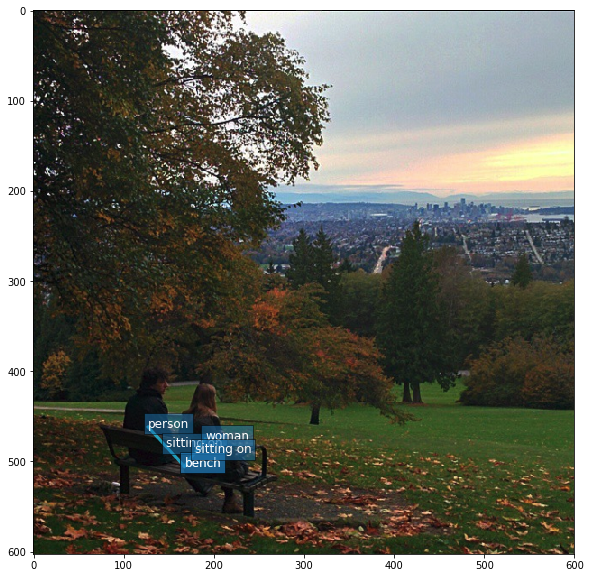

In [13]:
ax = plot_sg(img, preds, 2)